In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
import graphviz
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import category_encoders as ce
from pycaret.classification import *

In [2]:
df = pd.read_csv('shortCleanData.csv')
#df.drop(["Zeitpunkt der Erstellung",], axis=1, inplace=True)


In [3]:
#df = Mdf.sample(frac=1, random_state=42)
#df = df.iloc[:len(df)//4]
print(df.shape)
df.info()

(24639, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24639 entries, 0 to 24638
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   1-Abschluss                             24639 non-null  object
 1   1-Abschluss in DE                       24639 non-null  object
 2   1-Deutscher Ehepartner                  24639 non-null  object
 3   1-EB/NE erfllt?                         24639 non-null  object
 4   1-Einreisejahr                          24639 non-null  object
 5   1-Antrag EB                             24639 non-null  object
 6   1-Antrag NE                             24639 non-null  object
 7   1-Integrationstest                      24639 non-null  object
 8   1-Jahr AR beantragt/bekommen            24639 non-null  object
 9   1-Jobcenter                             24639 non-null  object
 10  1-Kinder                                24639 non-null  in

In [4]:
# Features and target
X = df.drop('SalesCount', axis=1)
y = df['SalesCount']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reset index to avoid future issues
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [5]:
# More debug information
print("Shapes after split - X_train:", X_train.shape, "y_train:", y_train.shape)
print("Shapes after split - X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes after split - X_train: (19711, 25) y_train: (19711,)
Shapes after split - X_test: (4928, 25) y_test: (4928,)


In [6]:
# Ignore specific columns
ignore_cols = ["Id","Zeitpunkt der Erstellung","Sales","Zeitpunkt der nderung","Zeitpunkt der Erstellung - Year","Zeitpunkt der nderung - Year"]

# Identify high-cardinality columns not in ignore list
high_card_cols = [col for col in X_train.columns if col not in ignore_cols and X_train[col].nunique() > 2 and X_train[col].dtype == 'object']

# Initialize and fit the encoder on the train data
loo_encoder = ce.LeaveOneOutEncoder(cols=high_card_cols, handle_unknown='value', handle_missing='value')



X_train_encoded = loo_encoder.fit_transform(X_train, y_train)



# Transform the test data using the fitted encoder
X_test_encoded = loo_encoder.transform(X_test)



In [7]:
# Handling NaN after encoding
print("NaN check in encoded data - X_train_encoded:", X_train_encoded.isnull().sum())
print("NaN check in encoded data - X_test_encoded:", X_test_encoded.isnull().sum())


NaN check in encoded data - X_train_encoded: 1-Abschluss                               0
1-Abschluss in DE                         0
1-Deutscher Ehepartner                    0
1-EB/NE erfllt?                           0
1-Einreisejahr                            0
1-Antrag EB                               0
1-Antrag NE                               0
1-Integrationstest                        0
1-Jahr AR beantragt/bekommen              0
1-Jobcenter                               0
1-Kinder                                  0
1-Netto                                   0
1-Rente                                   0
1-Sprachzertifikat                        0
1-Test Sprache                            0
1-Welches befristete AR haben Sie?        0
1-Wie ist ihr aktueller Familienstand?    0
1-Beratung?                               0
1-Gltiger Nationalpass                    0
Id                                        0
Zeitpunkt der Erstellung                  0
Sales                          

In [8]:


# # Replace unknown categories in test data encoded with the overall column mean from train data
# for col in high_card_cols:
#     if col in X_test_encoded:
#         X_test_encoded[col].fillna(X_train_encoded[col].mean(), inplace=True)


# Combine encoded features with the target for full train and test datasets
train_data = pd.concat([X_train_encoded, y_train.reset_index(drop=True)], axis=1)
#test_data = pd.concat([X_test_encoded, y_test.reset_index(drop=True)], axis=1)

In [9]:
# Final check before using in PyCaret
print("Final datasets - train_data:", train_data.shape, "test_data:", test_data.shape)
print(train_data.isnull().sum(), test_data.isnull().sum())

Final datasets - train_data: (19711, 26) test_data: (4928, 26)
1-Abschluss                               0
1-Abschluss in DE                         0
1-Deutscher Ehepartner                    0
1-EB/NE erfllt?                           0
1-Einreisejahr                            0
1-Antrag EB                               0
1-Antrag NE                               0
1-Integrationstest                        0
1-Jahr AR beantragt/bekommen              0
1-Jobcenter                               0
1-Kinder                                  0
1-Netto                                   0
1-Rente                                   0
1-Sprachzertifikat                        0
1-Test Sprache                            0
1-Welches befristete AR haben Sie?        0
1-Wie ist ihr aktueller Familienstand?    0
1-Beratung?                               0
1-Gltiger Nationalpass                    0
Id                                        0
Zeitpunkt der Erstellung                  0
Sales        

In [23]:
test_data

,1-Abschluss,1-Abschluss in DE,1-Deutscher Ehepartner,1-EB/NE erfllt?,1-Einreisejahr,1-Antrag EB,1-Antrag NE,1-Integrationstest,1-Jahr AR beantragt/bekommen,1-Jobcenter,...,1-Wie ist ihr aktueller Familienstand?,1-Beratung?,1-Gltiger Nationalpass,Id,Zeitpunkt der Erstellung,Sales,Zeitpunkt der nderung,Zeitpunkt der Erstellung - Year,Zeitpunkt der nderung - Year,SalesCount
0,0.045881,Nein,Ja,EB,0.072666,"Nein, ich habe noch keinen Antrag gestellt",Not Asked,Ja,0.067190,Nein,...,Verheiratet,Ja,Ja,318.777.000.092.792.278,1/3/2024 23:01,0,1/3/2024 23:01,2024,2024,0
1,0.061343,Ja,Not Asked,NE,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ja,0.047390,Nein,...,Ledig,Ja,Ja,318.777.000.080.337.922,11/24/2023 15:30,0,11/24/2023 15:30,2023,2023,0
2,0.060431,Ja,Not Asked,BOTH,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.058712,Nein,...,Ledig,Nein,Nein,318.777.000.083.408.303,12/3/2023 20:33,0,12/3/2023 20:33,2023,2023,0
3,0.069415,Not Asked,Not Asked,EB,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ja,0.072476,Nein,...,Ledig,Nein,Ja,318.777.000.084.426.510,12/6/2023 8:56,0,12/6/2023 8:56,2023,2023,0
4,0.060431,Ja,Ja,EB,0.061765,"Ja, mein Antrag wird aktuell bearbeitet",Not Asked,Ja,0.067190,Nein,...,Verheiratet,Nein,Ja,318.777.000.099.271.702,1/22/2024 0:30,0,1/22/2024 0:30,2024,2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,0.069415,Not Asked,Not Asked,BOTH,0.072666,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.047390,Nein,...,Ledig,Nein,Ja,318.777.000.093.608.291,1/6/2024 3:17,0,1/6/2024 3:17,2024,2024,0
4924,0.069415,Not Asked,Not Asked,NE,0.072666,"Ja, aber mein Antrag wurde abgelehnt",Not Asked,Ja,0.058712,Nein,...,Ledig,Ja,Ja,318.777.000.115.817.603,2/28/2024 18:47,0,2/28/2024 18:47,2024,2024,0
4925,0.057041,Ja,Nein,NE,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Nein,0.072476,Nein,...,Verheiratet,Ja,Ja,318.777.000.117.707.097,3/5/2024 19:04,0,3/5/2024 19:04,2024,2024,0
4926,0.061343,Ja,Not Asked,EB,0.048397,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.047390,Nein,...,Ledig,Nein,Ja,318.777.000.103.126.680,2/1/2024 15:31,0,2/1/2024 15:31,2024,2024,0


In [ ]:

# Combine into full datasets for pycaret
#train_data = pd.concat([X_train, y_train], axis=1)
#test_data = pd.concat([X_test, y_test], axis=1)


In [91]:
#df.drop(df.select_dtypes(include=['datetime64']).columns, axis=1, inplace=True)
#df.drop(["Grund_der_Absage","sales","Mailing_State","filered_sales.Other_State","filered_sales.Other_City","filered_sales.First_Visited_URL","filered_sales.sales","filered_sales.Mailing_State","filered_sales.id","id.1","Owner.1","Owner.2"], axis=1, inplace=True)
#df.info()

In [92]:
#from pycaret.classification import *

In [93]:
#import category_encoders as ce

In [4]:
#encoder = ce.LeaveOneOutEncoder()

In [9]:
# Reset the index of train_data and test_data
train_data = train_data.reset_index(drop=True)
#test_data = test_data.reset_index(drop=True)

In [11]:
if test_data.index.duplicated().any():
    print("here we go")
else:
    print("no go")

no go


In [10]:
#s = setup(df, target = 'SalesCount', ignore_features = ["Id","Zeitpunkt der Erstellung","Sales","Zeitpunkt der nderung","Zeitpunkt der Erstellung - Year","Zeitpunkt der nderung - Year"],max_encoding_ohe=10,normalize=True,normalize_method='minmax')
s = setup(train_data, target = 'SalesCount', ignore_features = ["Id","Zeitpunkt der Erstellung","Sales","Zeitpunkt der nderung","Zeitpunkt der Erstellung - Year","Zeitpunkt der nderung - Year"],max_encoding_ohe=5,train_size=0.95)

#s = setup(train_data, target = 'SalesCount', ignore_features = ["Id","Zeitpunkt der Erstellung","Sales","Zeitpunkt der nderung","Zeitpunkt der Erstellung - Year","Zeitpunkt der nderung - Year"],test_data=test_data)

,Description,Value
0,Session id,5628
1,Target,SalesCount
2,Target type,Binary
3,Original data shape,"(19711, 26)"
4,Transformed data shape,"(19711, 20)"
5,Transformed train set shape,"(18725, 20)"
6,Transformed test set shape,"(986, 20)"
7,Ignore features,6
8,Numeric features,17
9,Categorical features,2


In [11]:
test_Train = get_config("X_train_transformed")
test_Train

,1-Abschluss,1-Abschluss in DE,1-Deutscher Ehepartner,1-EB/NE erfllt?,1-Einreisejahr,1-Antrag EB,1-Antrag NE,1-Integrationstest,1-Jahr AR beantragt/bekommen,1-Jobcenter,1-Kinder,1-Netto,1-Rente,1-Sprachzertifikat,1-Test Sprache_Deutsch,1-Welches befristete AR haben Sie?,1-Wie ist ihr aktueller Familienstand?,1-Beratung?,1-Gltiger Nationalpass
6089,0.060243,0.057353,0.057777,0.068954,0.061886,0.056371,0.048884,0.063066,0.057820,0.072425,0.0,0.067803,0.058584,0.049806,1.0,0.069156,0.057761,0.0,0.056534
11504,0.061378,0.057446,0.057870,0.042053,0.062377,0.056431,0.081356,0.052006,0.058768,0.054060,0.0,0.057801,0.062670,0.070480,1.0,0.051832,0.057854,1.0,0.056592
5844,0.060443,0.057446,0.057870,0.059000,0.065339,0.056431,0.048984,0.063151,0.043619,0.054060,0.0,0.057801,0.058647,0.070480,1.0,0.014925,0.057854,0.0,0.056592
13626,0.045383,0.053671,0.066746,0.041744,0.047841,0.056371,0.048884,0.063066,0.046624,0.072425,3.0,0.072699,0.055682,0.070356,1.0,0.050967,0.058452,0.0,0.056534
10947,0.060443,0.057446,0.066914,0.069125,0.072681,0.069516,0.048984,0.052006,0.058768,0.054060,2.0,0.057801,0.073314,0.070480,1.0,0.014925,0.058576,0.0,0.056592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11962,0.057053,0.053886,0.057870,0.069125,0.072681,0.101724,0.048984,0.063151,0.065836,0.072602,2.0,0.068158,0.058647,0.070480,1.0,0.065733,0.057854,1.0,0.075377
12912,0.061378,0.057446,0.057870,0.059000,0.072681,0.056431,0.048984,0.054893,0.035176,0.054060,0.0,0.057801,0.058647,0.053665,1.0,0.023787,0.057854,0.0,0.056592
6770,0.069431,0.069431,0.057870,0.059000,0.065339,0.056431,0.048984,0.063151,0.043619,0.072602,2.0,0.073473,0.058647,0.053665,1.0,0.044849,0.057854,1.0,0.056592
10897,0.057053,0.057446,0.057870,0.069125,0.047556,0.053521,0.062189,0.054893,0.055834,0.036649,0.0,0.019688,0.058647,0.050159,1.0,0.059614,0.057854,1.0,0.056592


In [12]:
#best_model = compare_models(include=['lda'],sort='Recall')
best_model = compare_models(sort='Precision')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:00:07
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9999,0.0000,0.9991,1.0000,0.9995,0.9995,0.9995,0.0170
rf,Random Forest Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0630
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0620
gbc,Gradient Boosting Classifier,0.9998,1.0000,0.9973,1.0000,0.9986,0.9986,0.9986,0.1450
et,Extra Trees Classifier,0.9999,0.0000,0.9982,1.0000,0.9991,0.9990,0.9990,0.0590
lightgbm,Light Gradient Boosting Machine,0.9998,0.0000,0.9973,1.0000,0.9986,0.9986,0.9986,0.1350
knn,K Neighbors Classifier,0.9344,0.0000,0.0361,0.2116,0.0612,0.0440,0.0639,0.1960
lr,Logistic Regression,0.9408,0.7956,0.0018,0.1500,0.0036,0.0032,0.0153,0.2150
ridge,Ridge Classifier,0.9408,0.8016,0.0018,0.1500,0.0036,0.0032,0.0153,0.0160
lda,Linear Discriminant Analysis,0.9408,0.8001,0.0018,0.1500,0.0036,0.0031,0.0147,0.0160


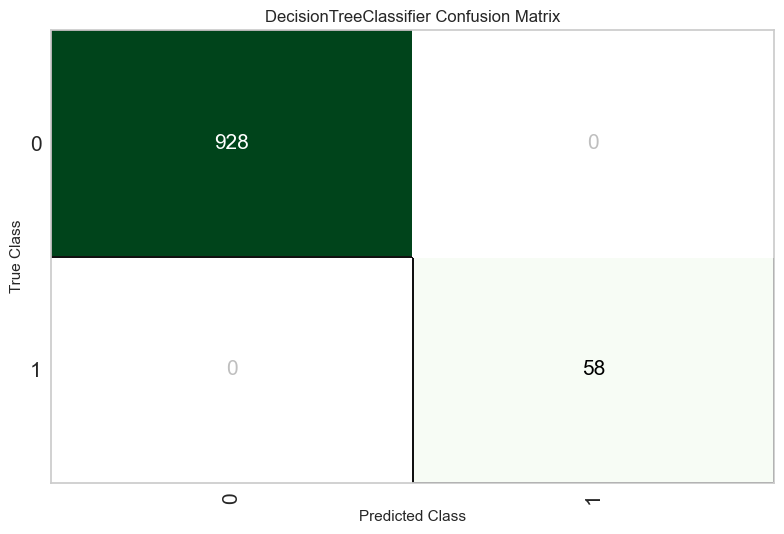

In [12]:
plot_model(best_model, plot = 'confusion_matrix')

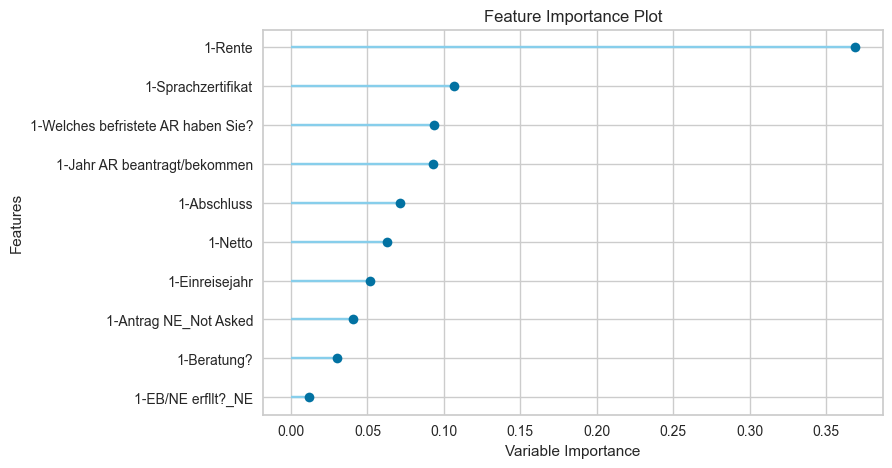

In [16]:
plot_model(best_model, plot = 'feature')

In [13]:
testModel = create_model('dt')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:00:27
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9995,0.0000,0.9910,1.0000,0.9955,0.9952,0.9952
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [14]:
predictions = predict_model(testModel,data=X_test_encoded)

In [20]:
predictions

,1-Abschluss,1-Abschluss in DE,1-Deutscher Ehepartner,1-EB/NE erfllt?,1-Einreisejahr,1-Antrag EB,1-Antrag NE,1-Integrationstest,1-Jahr AR beantragt/bekommen,1-Jobcenter,...,1-Beratung?,1-Gltiger Nationalpass,Id,Zeitpunkt der Erstellung,Sales,Zeitpunkt der nderung,Zeitpunkt der Erstellung - Year,Zeitpunkt der nderung - Year,prediction_label,prediction_score
0,0.045881,Nein,Ja,EB,0.072666,"Nein, ich habe noch keinen Antrag gestellt",Not Asked,Ja,0.067190,Nein,...,Ja,Ja,318.777.000.092.792.278,1/3/2024 23:01,0,1/3/2024 23:01,2024,2024,0,0.7659
1,0.061343,Ja,Not Asked,NE,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ja,0.047390,Nein,...,Ja,Ja,318.777.000.080.337.922,11/24/2023 15:30,0,11/24/2023 15:30,2023,2023,1,0.7566
2,0.060431,Ja,Not Asked,BOTH,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.058712,Nein,...,Nein,Nein,318.777.000.083.408.303,12/3/2023 20:33,0,12/3/2023 20:33,2023,2023,0,0.9979
3,0.069415,Not Asked,Not Asked,EB,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ja,0.072476,Nein,...,Nein,Ja,318.777.000.084.426.510,12/6/2023 8:56,0,12/6/2023 8:56,2023,2023,0,0.9997
4,0.060431,Ja,Ja,EB,0.061765,"Ja, mein Antrag wird aktuell bearbeitet",Not Asked,Ja,0.067190,Nein,...,Nein,Ja,318.777.000.099.271.702,1/22/2024 0:30,0,1/22/2024 0:30,2024,2024,0,0.9996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,0.069415,Not Asked,Not Asked,BOTH,0.072666,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.047390,Nein,...,Nein,Ja,318.777.000.093.608.291,1/6/2024 3:17,0,1/6/2024 3:17,2024,2024,0,1.0000
4924,0.069415,Not Asked,Not Asked,NE,0.072666,"Ja, aber mein Antrag wurde abgelehnt",Not Asked,Ja,0.058712,Nein,...,Ja,Ja,318.777.000.115.817.603,2/28/2024 18:47,0,2/28/2024 18:47,2024,2024,1,1.0000
4925,0.057041,Ja,Nein,NE,0.065321,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Nein,0.072476,Nein,...,Ja,Ja,318.777.000.117.707.097,3/5/2024 19:04,0,3/5/2024 19:04,2024,2024,1,0.6885
4926,0.061343,Ja,Not Asked,EB,0.048397,"Nein, ich habe noch keinen Antrag gestellt","Nein, ich habe noch keinen Antrag gestellt",Ich wei es nicht,0.047390,Nein,...,Nein,Ja,318.777.000.103.126.680,2/1/2024 15:31,0,2/1/2024 15:31,2024,2024,0,1.0000


In [15]:
# Extract predicted labels if needed
predicted_labels = predictions['prediction_label']

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print('Accuracy:', accuracy)


Accuracy: 0.9407467532467533


In [16]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:\n', conf_matrix)

Confusion Matrix:
 [[4636    0]
 [ 292    0]]


Confusion matrix, without normalization


IndexError: index 4636 is out of bounds for axis 1 with size 2

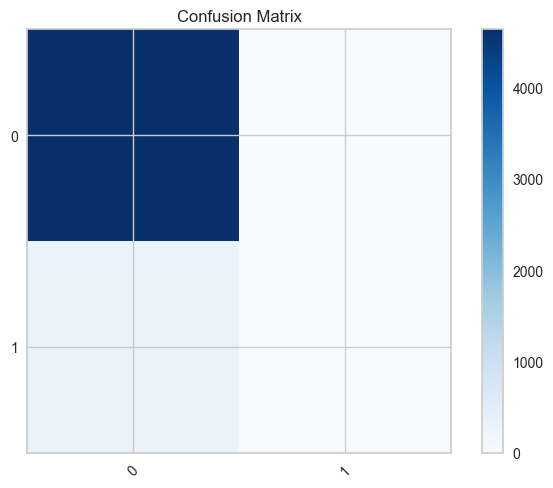

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print the values inside the matrix
    thresh = cm.max() / 2.
    for i, j in np.ndenumerate(cm):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Assuming 'classes' is the list of class labels
classes = ['0', '1']  # Modify as per your dataset

# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix')
plt.show()

In [25]:
# create copy of data
data_new = df.copy()
#data_new.drop('salesX', axis=1, inplace=True)
# generate labels using predict_model
finals=predict_model(best_model, data=data_new, raw_score=True)
finals.to_csv('shortSMOTE_LDA.csv', index=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7716,0.8674,0.7935,0.0215,0.0419,0.0300,0.1058


In [26]:
s2 = setup(df, target = 'Sales', ignore_features = ["Id"],fix_imbalance=True)

,Description,Value
0,Session id,436
1,Target,Sales
2,Target type,Binary
3,Original data shape,"(24640, 18)"
4,Transformed data shape,"(41670, 74)"
5,Transformed train set shape,"(34278, 74)"
6,Transformed test set shape,"(7392, 74)"
7,Ignore features,1
8,Ordinal features,1
9,Numeric features,1


In [27]:
best_model2 = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.2221,0.5958,0.9182,0.0074,0.0147,0.0022,0.0260,0.5400
qda,Quadratic Discriminant Analysis,0.1864,0.5405,0.9091,0.0070,0.0139,0.0014,0.0184,0.5220
svm,SVM - Linear Kernel,0.7819,0.0000,0.7364,0.0210,0.0408,0.0289,0.0987,0.5300
lda,Linear Discriminant Analysis,0.7791,0.8360,0.7355,0.0207,0.0402,0.0282,0.0976,0.5910
ridge,Ridge Classifier,0.7795,0.0000,0.7264,0.0205,0.0398,0.0279,0.0961,0.4640
lr,Logistic Regression,0.8101,0.8176,0.6800,0.0223,0.0432,0.0314,0.0986,2.2520
ada,Ada Boost Classifier,0.9602,0.8294,0.3127,0.0523,0.0893,0.0794,0.1147,1.4430
knn,K Neighbors Classifier,0.9370,0.5643,0.1655,0.0178,0.0321,0.0209,0.0361,0.9600
gbc,Gradient Boosting Classifier,0.9819,0.8181,0.1109,0.0479,0.0660,0.0582,0.0641,4.3940
dt,Decision Tree Classifier,0.9868,0.5232,0.0555,0.0550,0.0543,0.0478,0.0482,0.7980


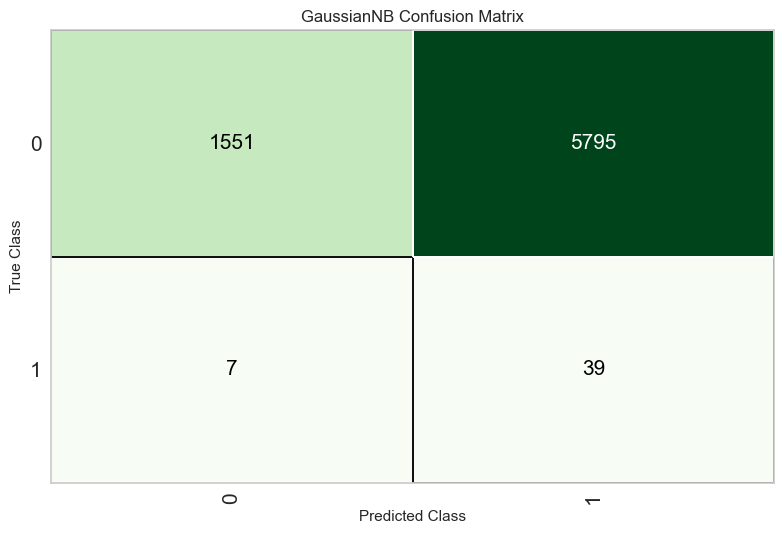

In [28]:
plot_model(best_model2, plot = 'confusion_matrix')

In [29]:
best_model3 = compare_models(include=['lda'],sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7797,0.8357,0.7355,0.0207,0.0403,0.0284,0.0978,0.9180


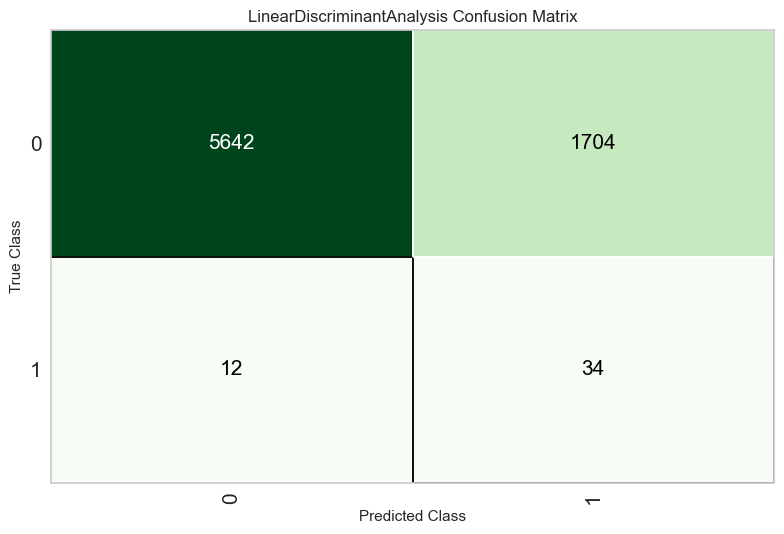

In [30]:
plot_model(best_model3, plot = 'confusion_matrix')

In [44]:
# create copy of data
#data_new = df.copy()
#data_new.drop('salesX', axis=1, inplace=True)
# generate labels using predict_model
finals=predict_model(best_model3, raw_score=True)
finals.to_csv('short_LDA.csv', index=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,CustomeTest
0,Linear Discriminant Analysis,0.7679,0.8110,0.7391,0.0196,0.0381,0.0263,0.0940,0


In [32]:
best_model4 = compare_models(include=['gbc'],sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9828,0.8163,0.1382,0.0684,0.0863,0.0788,0.0864,5.1910


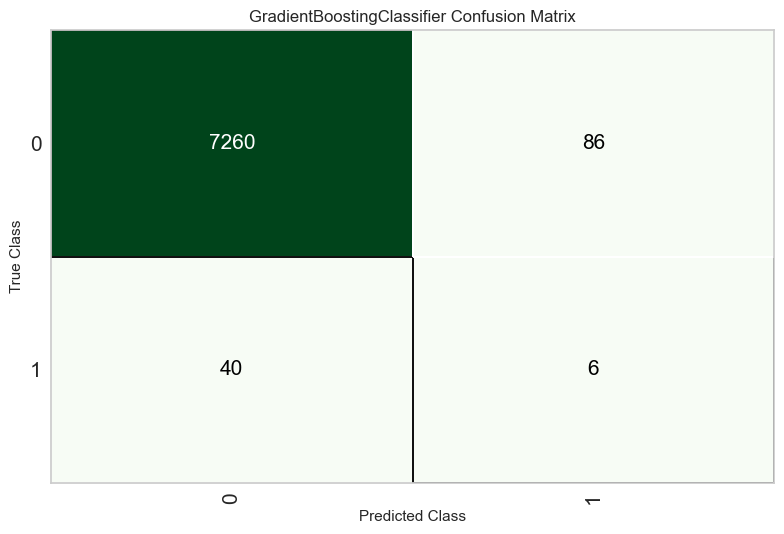

In [34]:
plot_model(best_model4, plot = 'confusion_matrix')

In [36]:
# # create a custom function
# def calculate_profit(y, y_pred):
#     tp = np.where((y_pred==1) & (y==1), (1500-15), 0)
#     fp = np.where((y_pred==1) & (y==0), -15, 0)
#     fn = np.where((y_pred==0) & (y==1), -1500, 0)
#     return np.sum([tp,fp,fn])
# # add metric to PyCaret
# add_metric('profit', 'Profit', calculate_profit)

def custom_metric(y,y_pred):
    tp = np.where((y_pred==1)&(y==1),1,0)
    fp = np.where((y_pred==1)&(y==0),-1,0)
    fn = np.where((y_pred==0)&(y==1),-0.5,0)
    return np.sum([tp,fp,np])

add_metric('customTest','CustomeTest',custom_metric)

Name                                                       CustomeTest
Display Name                                               CustomeTest
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                      make_scorer(custom_metric)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: customTest, dtype: object

In [39]:
best_model5 = compare_models(probability_threshold=0.75,sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,CustomeTest,TT (Sec)
qda,Quadratic Discriminant Analysis,0.2004,0.5702,0.9273,0.0073,0.0145,0.0020,0.0244,0.0000,0.4790
nb,Naive Bayes,0.2235,0.6036,0.9182,0.0074,0.0147,0.0022,0.0261,0.0000,0.4740
ridge,Ridge Classifier,0.7786,0.0000,0.7255,0.0204,0.0396,0.0276,0.0956,0.0000,0.3880
svm,SVM - Linear Kernel,0.8033,0.0000,0.6709,0.0217,0.0421,0.0302,0.0952,0.0000,0.5350
lda,Linear Discriminant Analysis,0.8846,0.8363,0.5691,0.0310,0.0588,0.0474,0.1127,0.0000,0.5770
lr,Logistic Regression,0.9009,0.8181,0.5045,0.0324,0.0608,0.0495,0.1085,0.0000,1.7170
knn,K Neighbors Classifier,0.9572,0.5643,0.0918,0.0158,0.0269,0.0163,0.0231,0.0000,0.8450
dt,Decision Tree Classifier,0.9870,0.5279,0.0645,0.0690,0.0646,0.0582,0.0592,0.0000,0.6930
rf,Random Forest Classifier,0.9935,0.6778,0.0000,0.0000,0.0000,-0.0003,-0.0005,0.0000,2.0660
ada,Ada Boost Classifier,0.9937,0.8233,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.3310


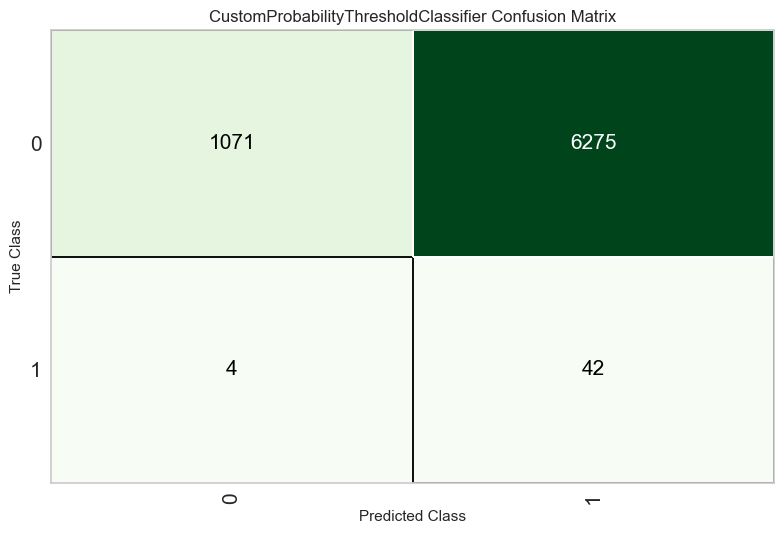

In [40]:
plot_model(best_model5, plot = 'confusion_matrix')

In [42]:
best_model6 = compare_models(include=['svm'],probability_threshold=0.75,sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,CustomeTest,TT (Sec)
svm,SVM - Linear Kernel,0.7924,0.0000,0.7264,0.0219,0.0425,0.0306,0.1010,0.0000,1.0950


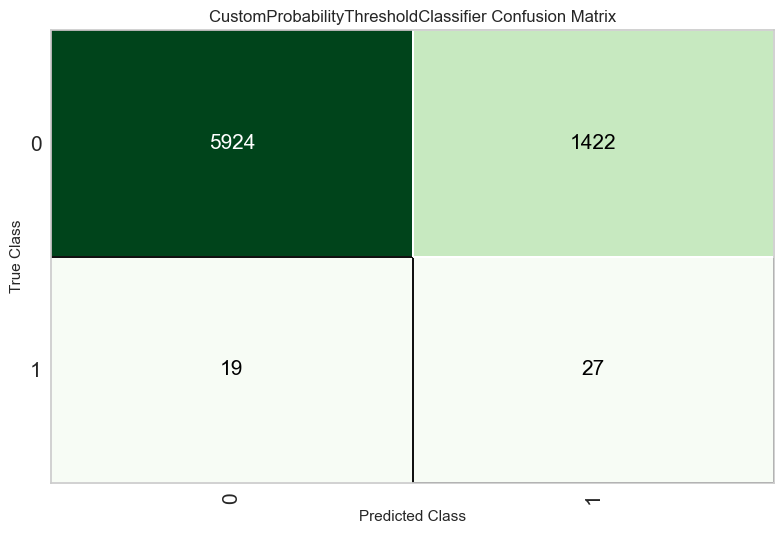

In [43]:
plot_model(best_model6, plot = 'confusion_matrix')

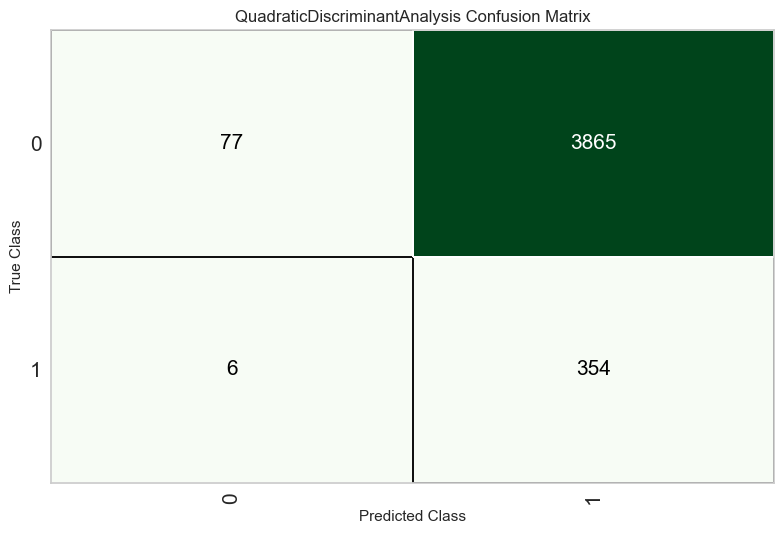

In [57]:
plot_model(best_model, plot = 'confusion_matrix')